In [1]:
import os
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import uuid

In [2]:
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Flatten
from keras.layers import Lambda
from keras.models import Model  #the functional API

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Making required directories**

In [4]:
#setting up the directory structure for our project. Namely, three folders Anchor, Negative, Positive
pos_path = os.path.join('data', 'positive')         #positive images (verification images)
neg_path = os.path.join('data', 'negative')         #negative images (different from the anchor images)
anc_path = os.path.join('data', 'anchor')           #input image (object to be recognized)

In [5]:
if not os.path.exists(pos_path):
    os.makedirs(pos_path)
if not os.path.exists(neg_path):
    os.makedirs(neg_path)
if not os.path.exists(anc_path):
    os.makedirs(anc_path)
#first, we collect the negative examples through Labelled Faces in the wild repository
#first download the required files from the website into the working directory. Then run the cell

! tar -xf lfw.tgz

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(neg_path, file)
        os.replace(EX_PATH, NEW_PATH)

"""
first we loop over every sub directory in the lfw folder. Then for every file in each sub directory, we get the path of the file, create a new path for the
file and the replace the two paths (in effect cutting the files from the initial location to the final location)"""

'\nfirst we loop over every sub directory in the lfw folder. Then for every file in each sub directory, we get the path of the file, create a new path for the\nfile and the replace the two paths (in effect cutting the files from the initial location to the final location)'

# **Writing a function to capture User's image through the webcam**

In [7]:
#capturing the anchor and the positive images using our webcam and opencv
#step1. establish a connection to the webcam using VideoCapture()
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow("Image Collection", frame)
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break
#Release the webcam and destroy the image show frame
cap.release()
cv2.destroyAllWindows()

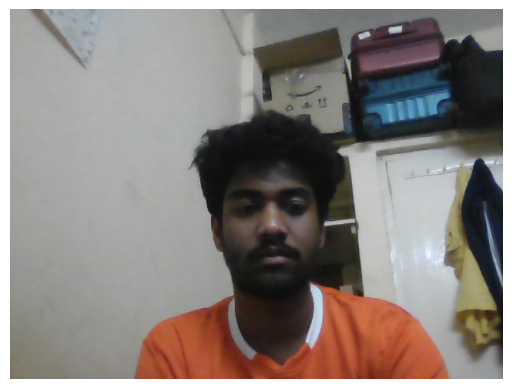

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()
#this is actually the last frame captured by the camera before i pressed q (as soon as it is pressed, the image capture stops)

In [9]:
#However, the resolution is large and needs to be reduced for processing
#for this we make a change to the original image capturing function
#capturing the anchor and the positive images using our webcam and opencv
#step1. establish a connection to the webcam using VideoCapture()
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:370, 200:450, :]  #arbitrary values
    #collecting anchor images
    if(cv2.waitKey(1) & 0XFF == ord('a')):
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        print("Anchor Image Captured")

    #collecting positive images
    if(cv2.waitKey(1) & 0XFF == ord('p')):
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        print("Positive Image Captured")

    cv2.imshow("Image Collection", frame)
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break
#Release the webcam and destroy the image show frame
cap.release()
cv2.destroyAllWindows()

Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Anchor Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured
Positive Image Captured


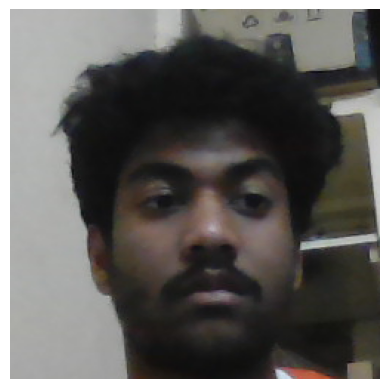

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()
#last image captured by the camera. Also, in this case, the resolution is smaller than the pervious case

In [11]:
def data_aug(img):
    data = []
    for i in range(5):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [12]:
for file_name in os.listdir(os.path.join(pos_path)):
    if os.path.isdir(os.path.join(pos_path, file_name)):
        continue

    img_path = os.path.join(pos_path, file_name)

    img = cv2.imread(img_path)
    augmented_images = data_aug(img)     
    for image in augmented_images:
        cv2.imwrite(os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [13]:
for file_name in os.listdir(os.path.join(anc_path)):
    if os.path.isdir(os.path.join(pos_path, file_name)):
        continue
    img_path = os.path.join(anc_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# **Image Preprocessing & Model Building for the Neural Network**

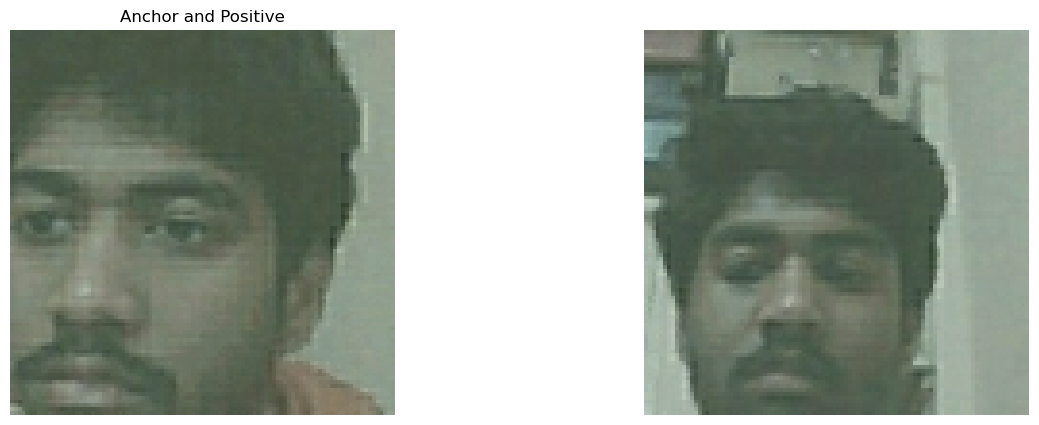

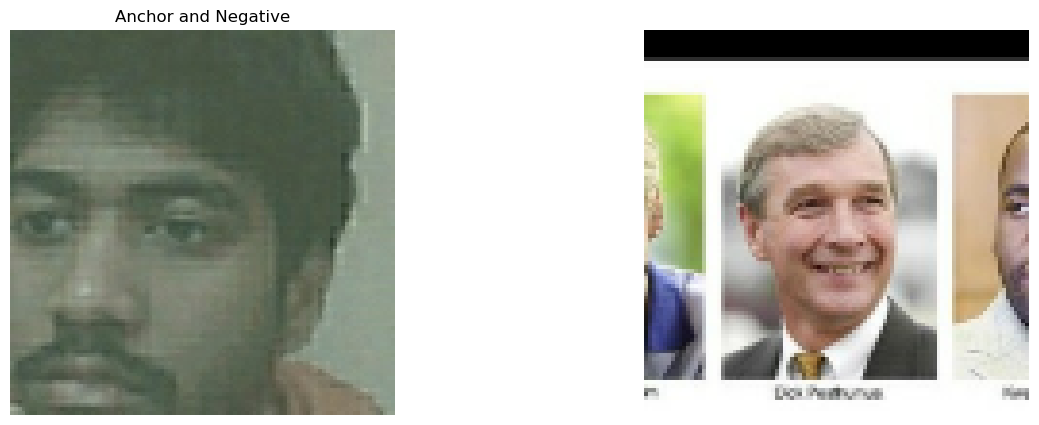

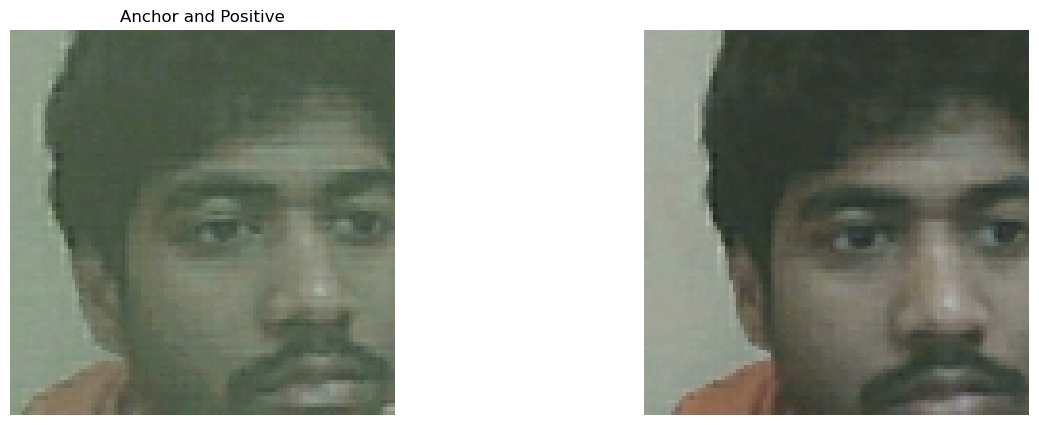

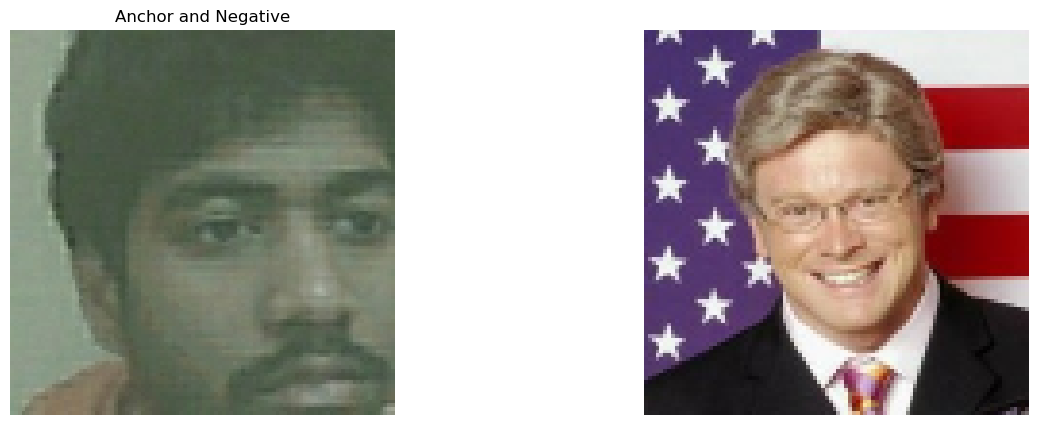

In [61]:
# Function to preprocess an image
def preprocess(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (100, 100))
    return image

# Function to check if an image has the expected shape
def is_valid_image(image):
    return len(image.shape) == 3 and image.shape == (100, 100, 3)

# Function to generate pairs and labels from a dataset
def generate_pairs_and_labels(data):
    pairs = []
    labels = []

    for anchor, positive, negative in data:
        anchor_img = preprocess(anchor)

        positive_img = preprocess(positive)

        negative_img = preprocess(negative)

        if is_valid_image(anchor_img) and is_valid_image(positive_img) and is_valid_image(negative_img):
            pairs.append((anchor_img, positive_img))
            labels.append(1)  # Positive pair

            pairs.append((anchor_img, negative_img))
            labels.append(0)  # Negative pair

    return np.array(pairs), np.array(labels)

# Function to visualize a set of images
def visualize_images(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        if i == 0 :
            plt.title(title)
        if i == 2: 
            plt.title(title)
        plt.axis('off')
    plt.show()

# Loading dataset from directories
anchor_data = tf.data.Dataset.list_files("data/anchor/*.jpg").take(300)

positive_data = tf.data.Dataset.list_files("data/positive/*.jpg").take(300)

negative_data = tf.data.Dataset.list_files("data/negative/*.jpg").take(300)


# Loading images and create pairs
data = tf.data.Dataset.zip((anchor_data.map(tf.io.read_file), positive_data.map(tf.io.read_file), negative_data.map(tf.io.read_file)))
data = data.map(lambda a, p, n: (tf.io.decode_jpeg(a), tf.io.decode_jpeg(p), tf.io.decode_jpeg(n)))
# Generating pairs and labels
pairs, labels = generate_pairs_and_labels(data)

# Visualizing a few pairs
visualize_images([pairs[0][0], pairs[0][1]], 'Anchor and Positive')
visualize_images([pairs[1][0], pairs[1][1]], 'Anchor and Negative')
visualize_images([pairs[2][0], pairs[2][1]], 'Anchor and Positive')
visualize_images([pairs[3][0], pairs[3][1]], 'Anchor and Negative' )

In [62]:
# Split data into training and testing sets
split_index = int(0.8 * len(pairs))
train_pairs, test_pairs = pairs[:split_index], pairs[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

In [69]:
# Build Siamese network model
input_shape = (100, 100, 3)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

input_anchor = tf.keras.layers.Input(shape=input_shape)
input_positive = tf.keras.layers.Input(shape=input_shape)
input_negative = tf.keras.layers.Input(shape=input_shape)

encoded_anchor = base_model(input_anchor)
encoded_positive = base_model(input_positive)
encoded_negative = base_model(input_negative)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1)
flat_output = tf.keras.layers.Flatten()(merged_vector)
dense_layer = tf.keras.layers.Dense(256, activation='relu')(flat_output)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

siamese_model = tf.keras.models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=output_layer)

In [70]:
# Compiling the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(train_pairs.shape)
print(test_pairs.shape)

# Training the model
siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1], train_pairs[:, 1]], train_labels, epochs=10, batch_size=32, validation_data=([test_pairs[:, 0], test_pairs[:, 1], test_pairs[:, 1]], test_labels))

(480, 2, 100, 100, 3)
(120, 2, 100, 100, 3)
Epoch 1/10
15/15 [==============================] - 20s 1s/step - loss: 4.9024 - accuracy: 0.5479 - val_loss: 0.6077 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 14s 920ms/step - loss: 0.4987 - accuracy: 0.7063 - val_loss: 0.2912 - val_accuracy: 0.9250
Epoch 3/10
15/15 [==============================] - 14s 924ms/step - loss: 0.2252 - accuracy: 0.9563 - val_loss: 0.3008 - val_accuracy: 0.8667
Epoch 4/10
15/15 [==============================] - 14s 926ms/step - loss: 0.1696 - accuracy: 0.9521 - val_loss: 0.2131 - val_accuracy: 0.9000
Epoch 5/10
15/15 [==============================] - 14s 922ms/step - loss: 0.1468 - accuracy: 0.9646 - val_loss: 0.1630 - val_accuracy: 0.9667
Epoch 6/10
15/15 [==============================] - 14s 950ms/step - loss: 0.1184 - accuracy: 0.9625 - val_loss: 0.1385 - val_accuracy: 0.9417
Epoch 7/10
15/15 [==============================] - 14s 955ms/step - loss: 0.1091 - accuracy: 0.9750 

# **Real Time test**

In [71]:
evaluation = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1], test_pairs[:, 1]], test_labels)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 [==============================] - 3s 623ms/step - loss: 0.0962 - accuracy: 0.9750
Test Loss: 0.09617757797241211
Test Accuracy: 0.9750000238418579


In [72]:
# Function to preprocess an image
def preprocess(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (100, 100))
    return image

# Function to verify using the Siamese model
def verify(model, detection_threshold, verification_threshold):
    results = []

    input_img = preprocess(cv2.imread(os.path.join('application_data', 'input_image', 'input_image.jpg')))
    verification_img = preprocess(cv2.imread(os.path.join('application_data', 'verification_images', 'verification_image.jpg')))
    
    negative_images = tf.data.Dataset.list_files("data/negative/*.jpg").take(1)
    negative_image = negative_images.map(tf.io.read_file).map(tf.io.decode_jpeg).repeat().batch(1).as_numpy_iterator().next()[0]
    input_negative = preprocess(negative_image)

    result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(verification_img, axis=0), np.expand_dims(input_negative, axis=0)])
    results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(results)
    verified = verification > verification_threshold
    
    return results, verified

# Create directories if they don't exist
app_path = os.path.join('application_data', 'verification_images')
if not os.path.exists(app_path):
    os.makedirs(app_path)

input_path = os.path.join('application_data', 'input_image')
if not os.path.exists(input_path):
    os.makedirs(input_path)

# Open the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('Verification(v), input(i)', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save verification image
        cv2.imwrite(os.path.join('application_data', 'verification_images', 'verification_image.jpg'), frame)
        print('Verification image captured')

    # Input trigger
    if cv2.waitKey(10) & 0xFF == ord('i'):
        # Save input image
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        print('Input image captured')

        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(f"Verification Results: {results}, Verified: {verified}")

    # Quit the application
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Verification image captured
Input image captured
1/1 [==============================] - 2s 2s/step
Verification Results: [array([[0.01059531]], dtype=float32)], Verified: False
Input image captured
1/1 [==============================] - 0s 115ms/step
Verification Results: [array([[3.309729e-06]], dtype=float32)], Verified: False
Input image captured
1/1 [==============================] - 0s 139ms/step
Verification Results: [array([[0.00365697]], dtype=float32)], Verified: False
Input image captured
1/1 [==============================] - 0s 124ms/step
Verification Results: [array([[0.04259175]], dtype=float32)], Verified: False
Input image captured
1/1 [==============================] - 0s 142ms/step
Verification Results: [array([[0.06162799]], dtype=float32)], Verified: False
Input image captured
1/1 [==============================] - 0s 128ms/step
Verification Results: [array([[6.800078e-05]], dtype=float32)], Verified: False


In [73]:
np.sum(np.squeeze(results) > 0.9)

0

In [74]:
results

[array([[6.800078e-05]], dtype=float32)]